# TP4: Vers le deep hedging

## par: Belgnaoui Mohammed Taha





## Objectif  

Dans le cadre d'un **call européen** sous le modèle de Black-Scholes en dimension 1 (BS 1D), l'objectif est d'implémenter une **couverture optimale en moyenne quadratique** en utilisant des **réseaux de neurones**.  
Nous comparerons la stratégie obtenue avec la fonction **Delta** théorique, qui correspond à la dérivée du prix du call par rapport au sous-jacent.  

## Approche par Réseau de Neurones  

À l'image de la **dépendance du Delta théorique** vis-à-vis de l'instant $t$ et du prix du sous-jacent $S_t$, nous implémentons un **réseau de neurones** qui prend en entrée un **tuple** :  

$$
(t, S_t)
$$  

où :  
- $t$ est l'instant actuel,  
- $S_t$ est le prix du sous-jacent à cet instant.  

En sortie, le réseau de neurones prédit une **valeur de Delta**, qui est utilisée pour la stratégie de couverture.  
Nous **normalisons également nos données** afin d'améliorer les résultats.  

## Fonction de Profit et Perte (PnL)  

La stratégie vise à minimiser la fonction de **PnL ajustée** :  

$$
\tilde{PnL}_{0,T} = P_0 + \sum_{i=0}^{N-1} \delta_i (\tilde{S}_{i+1} - \tilde{S}_i) - e^{-rT} \psi(S_T)
$$

où :  
- $P_0$ est le prix initial du portefeuille,  
- $\delta_i$ est la quantité de sous-jacent détenue au temps $t_i$, prédite par le réseau de neurones,  
- $\tilde{S}_{i}$ est la valeur simulée du sous-jacent au temps $t_i$,    
- $e^{-rT} \psi(S_T)$ représente la valeur actualisée du **payoff** du call européen :  

$$
\psi(S_T) = \max(S_T - K, 0)
$$  

## Comparaison avec le Delta Théorique  

Nous affichons la **fonction Delta** à chaque pas de temps et comparons la stratégie apprise avec la couverture **théorique** donnée par la formule de Black-Scholes.  

## Structure du Réseau de Neurones  

Le **Delta** théorique prend des valeurs entre **0 et 1**, ce qui motive l'utilisation d'une **fonction sigmoïde** en sortie du réseau de neurones afin de contraindre les prédictions dans cet intervalle.  

 



In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()
import torch
import torch.nn as nn


In [16]:
from tqdm import tqdm

In [3]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return result

In [5]:
N=10
x0=100
sigma=0.25
r = 0.1
T = 1
K = 100
dt = T / N

In [6]:
from scipy.stats import norm

def d1(spot, t, r=r, sigma=sigma, strike=K):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r=r, sigma=sigma, strike=K):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def dprice_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    return norm.cdf(d1(spot, t, r, sigma, strike))

In [7]:
def simu_S(N, M): 
    h = T/N
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(N, M))
    sample = np.zeros(shape=(N+1, M))
    sample[0] = x0
    for n in range(1, N+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [8]:
P0e = price_call_BS(x0, T, r, sigma, K)
print("Prix exact:", P0e)

Prix exact: 14.9757907783113


In [10]:
N, M = 10, int(1e6)
sample = simu_S(N, M)
sample_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * sample

In [11]:
delta = np.zeros_like(sample)
for n in range(N): 
    delta[n] = dprice_call_BS(sample[n], (N-n)*T/N)

value = np.zeros_like(sample)
value[0] = P0e - delta[0] * sample_act[0]   # on peut changer en P0m
for n in range(1,N):
    value[n] = value[n-1] - (delta[n] - delta[n-1]) * sample_act[n]
value[N] = value[N-1] + delta[N-1] * sample_act[N] - np.exp(-r*T)*np.maximum(sample[N]-K, 0)

### Construction du nn 

In [12]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size):
        super().__init__()
        layers = [nn.Linear(input_size, layer_sizes[0]), nn.Tanh()]  
        for (ls_in, ls_out) in zip(layer_sizes, layer_sizes[1:]):
            layers.append(nn.Linear(ls_in, ls_out))
            layers.append(nn.ReLU())  
        
        layers.append(nn.Linear(layer_sizes[-1], output_size))  
        layers.append(nn.Sigmoid())  # Sigmoïde à la fin

        self.linear_tanh_stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.linear_tanh_stack(x)



In [13]:
# Calcul de constante de normalisation
paths = simu_S(N, 1000000)
mean_S = np.mean(paths, axis=1, keepdims=True)
std_S = np.std(paths, axis=1, keepdims=True) + 1e-10

nsimu=100000 #nombre de mise à jour des paramétres du nn
M=20 # nombre de trjectoire à chaque mise à jour 
learning_rate=0.001

### Apprentissage

In [14]:
def Deep_Hedging(x0=100, r=0.1, sigma=0.25, T=1, K=100, N=10, nsimu=100000, M=20, learning_rate=0.001):
    dt = T / N

    
    model = NeuralNetwork(input_size=2, layer_sizes=[16, 32, 16], output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()

    
    

    for _  in tqdm(range(nsimu)):
        
        paths = simu_S(N, M)
        S_norm = (paths - mean_S) / std_S

        # Calcul de l'incrément du prix actualisé
        discount_factors = np.exp(-r * dt * np.arange(N + 1))
        paths_discounted = paths * discount_factors[:, None]
        delta_S = torch.tensor(np.diff(paths_discounted, axis=0)).float()

        # Création des données d'entrée pour le modèle
        time_to_maturity = (T - dt * np.arange(N)) / T
        S_trimmed = S_norm[:-1]
        t_mat_expanded = np.tile(time_to_maturity.reshape(-1, 1), (1, M))

        data = np.stack([S_trimmed, t_mat_expanded], axis=2)
        data = torch.tensor(data, dtype=torch.float32)

        # Passage dans le modèle
        o = model(data).squeeze(-1)

        # Calcul de PnL
        delta_pnl = (delta_S * o).sum(dim=0)

        
        
        

        phi = torch.tensor(np.exp(-r * T) * np.maximum(paths[-1] -K , 0)).float()
        # Calcul de la perte
        
        loss = torch.mean((+phi -delta_pnl) ** 2)
        # Rétropropagation
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()




    return model

In [17]:
model = Deep_Hedging(x0, r, sigma, T, K, N, nsimu, M, learning_rate)

100%|██████████| 100000/100000 [06:23<00:00, 260.93it/s]


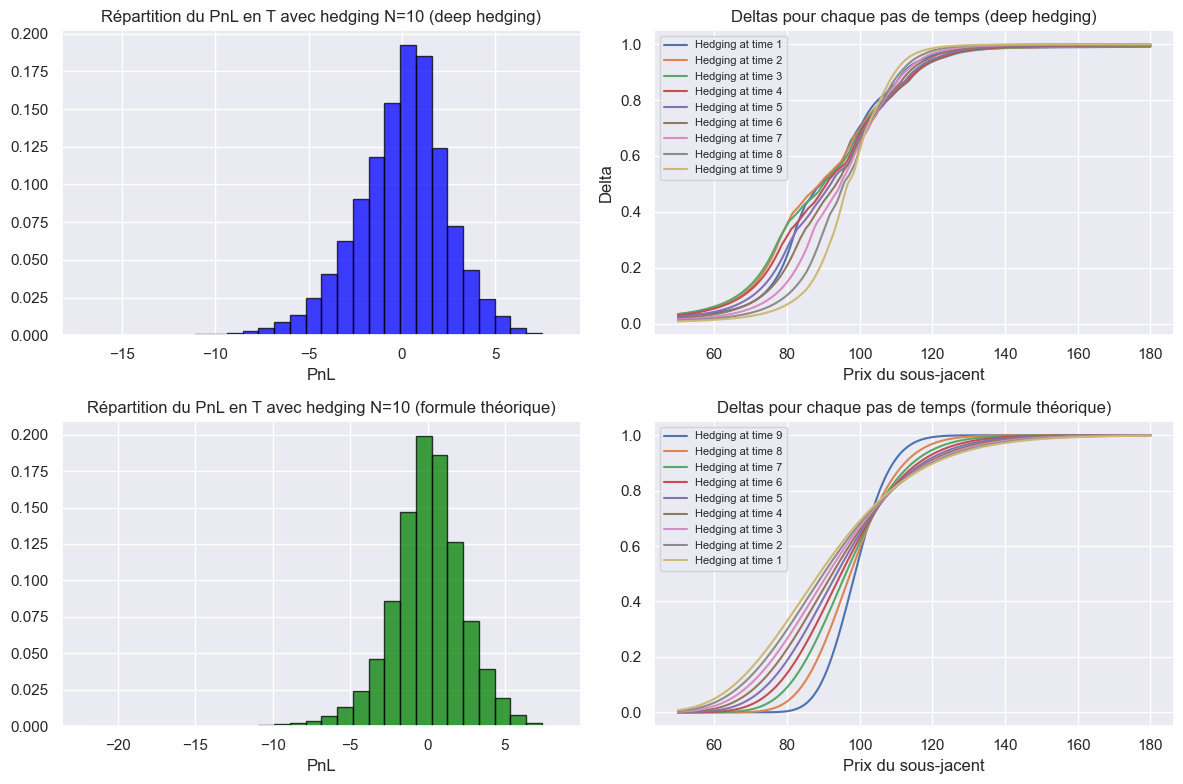

In [18]:

# Simulation des chemins de prix
paths = simu_S(N, nsimu)

# Normalisation des prix
S_norm = (paths - mean_S) / std_S

# Actualisation des prix
discount_factors = np.exp(-r * dt * np.arange(N + 1))
paths_discounted = paths * discount_factors[:, None]

# Création des données d'entrée pour le modèle
time_to_maturity = (T - dt * np.arange(N)) / T
S_trimmed = S_norm[:-1]
t_mat_expanded = np.tile(time_to_maturity.reshape(-1, 1), (1, nsimu))

data = np.stack([S_trimmed, t_mat_expanded], axis=2)
data = torch.tensor(data, dtype=torch.float32)

# Passage dans le modèle
o = model(data).squeeze(-1)

# Calcul de l'incrément du prix actualisé
delta_S = np.diff(paths_discounted, axis=0)

delta_pnl = P0e + (delta_S * o.detach().numpy()).sum(axis=0) - np.exp(-r * T) * np.maximum(paths[-1] - K, 0)

# Stockage des résultats
pnl_list = [delta_pnl]
delta_list = [o.detach().numpy()]

# Création des graphiques bien organisés
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axes.flatten()  # Déplier les axes pour un accès plus simple

# Histogramme du PnL
ax1.hist(np.concatenate(pnl_list), bins=30, density=True, alpha=0.75, color="blue", edgecolor="black")
ax1.set_title(f"Répartition du PnL en T avec hedging N={N} (deep hedging)")
ax1.set_xlabel("PnL")

ax1.grid(True)

# Tracés des deltas
xx = np.linspace(50, 180, nsimu)  
paths = np.tile(xx, (11, 1))  
S_norm = (paths - mean_S) / std_S
time_to_maturity = (T - dt * np.arange(N)) / T
S_trimmed = S_norm[:-1]
t_mat_expanded = np.tile(time_to_maturity.reshape(-1, 1), (1, nsimu))

data = np.stack([S_trimmed, t_mat_expanded], axis=2)
data = torch.tensor(data, dtype=torch.float32)

o = model(data).squeeze(-1)
delta_list = [o.detach().numpy()]

for i in range(1, 10):
    ax2.plot(paths[i, :], delta_list[0][i, :], label=f"Hedging at time {i}")
ax2.set_title("Deltas pour chaque pas de temps (deep hedging)")
ax2.set_xlabel("Prix du sous-jacent")
ax2.set_ylabel("Delta")
ax2.legend(loc="best", markerscale=5, fontsize=8)
ax2.grid(True)


ax3.hist(value[N], bins=30, density=True, alpha=0.75, color="green", edgecolor="black")
ax3.set_title(f"Répartition du PnL en T avec hedging N={N} (formule théorique)")
ax3.set_xlabel("PnL")

ax3.grid(True)


for n in reversed(range(1, N)):
    ax4.plot(xx, dprice_call_BS(xx, (N-n)*T/N), label=f"Hedging at time {n}")
ax4.set_title("Deltas pour chaque pas de temps (formule théorique)")
ax4.set_xlabel("Prix du sous-jacent")

ax4.legend(loc="best", fontsize=8)
ax4.grid(True)


plt.tight_layout()


plt.show()


## Conclusion  

La méthode de **Deep Hedging** par réseaux de neurones parvient à approximer la **fonction Delta** (fonction de répartition) et à reproduire l'histogramme du **PnL** avec une bonne précision.  

L'introduction d'une **sigmoïde** à la sortie de notre réseau améliore la précision des prédictions.  

Le résultat obtenu grâce au réseau de neurones est généralement moins rapide, en raison de la complexité du processus d'entraînement.  

Cependant, le **Deep Hedging** présente l'avantage de s'adapter à des environnements plus réalistes, où on a pas de formule fermée.  

